In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [25]:
path = "/content/optdigits.tra"
data_optdigit = pd.read_csv(path, header = None)
data_optdigit.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,16,6,6,10,0,0,0,8,16,2,0,11,2,0,0,5,16,3,0,5,7,0,0,7,13,3,0,8,7,0,0,4,12,0,1,13,5,0,0,0,14,9,15,9,0,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,16,8,16,5,0,0,0,11,16,0,6,14,3,0,0,12,12,0,0,11,11,0,0,12,12,0,0,8,12,0,0,7,15,1,0,13,11,0,0,0,16,8,10,15,3,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,11,9,11,16,1,0,0,0,0,0,7,14,0,0,0,0,3,4,14,12,2,0,0,1,16,16,16,16,10,0,0,2,12,16,10,0,0,0,0,0,2,16,4,0,0,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,5,16,11,13,7,0,0,3,15,8,1,15,6,0,0,11,16,16,16,16,10,0,0,1,4,4,13,10,2,0,0,0,0,0,15,4,0,0,0,0,0,3,16,0,0,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,13,8,0,0,0,0,0,3,14,4,0,0,0,0,0,6,16,14,9,2,0,0,0,4,16,3,4,11,2,0,0,0,14,3,0,4,11,0,0,0,10,8,4,11,12,0,0,0,4,12,14,7,0,0,6


In [27]:
X_digits = data_optdigit[np.arange(64)] #Data without class label
Y_digits = data_optdigit[64] #Class Label

In [28]:
def feature_normalize(x):
    n = x.shape[1]
    mean = np.zeros((1, n))
    
    # Calculate the mean for each column
    mean = np.mean(x, axis=0)
    
    # For each value normalized
    for i in range(n):
      x.loc[:, i] = (x.loc[:, i] - mean[i])
    return x

##**Implementing LDA Algorithm**

**Steps:**

1.   Firstly, we create a mean vector of each feature for every class.
2.   Then, we compute the within class(SW) and between class(SB) scatter matrices.
3.   Next, we find the eigenvalues and eigenvectors using within class and between class scatter matrices.
4.   Sort the eigenvalues and select the top k
5.   We create a new matrix containing eigenvectors that map to the k eigenvalues called named as projection matrix
6.   Finally, we obtain the new features (LDA components) by taking the dot product of the data and the projection matrix

### **First Step for LDA**

Create a mean vector of each feature for every class using the following formula:

>$m_i=  \frac{1}{N_i}\sum_{x€C_i}^{N} x_k$  where x is a sample (i.e. row) and n is the total number of samples with a given class.


### **Second Step For LDA**

We calculate the within class scatter matrix using the following formula:

>$S_i = \sum_{x€C_i}^{n} (x-m_i)(x-m_i)^T$

>$S_W=  \sum_{i=1}^{c} S_i$  where c is the total number of distinct classes 


We calculate the between class scatter matrix using the following formula:


>$m_i=  \frac{1}{n_i}\sum_{x€C_i}^{N} x_k$  


>$m=  \frac{1}{n}\sum_{i=1}^{n} x_i$  

> $S_B=  \sum_{i=1}^{c} N_i(m_i - m)(m_i - m)^T$ 

In [29]:
class LDA():
  """
  k: number of components
  w: projection matrix
  sw: Within Scatter Matrix
  sb: Between Scatter Matrix
  """

  def __init__(self,k,data,Y):
    self.k = k
    self.eig_vals = None
    self.eig_vecs = None
    self.data = data
    self.Y = Y
    self.n = data.shape[1] -1

  #Create mean vector for each class
  def mean_vectors(self):
    mean_vectors = pd.DataFrame()
    for c, rows in self.data.groupby(self.Y):
      mean_vectors[c] = rows.mean()
    mean_vectors.drop([64],axis=0,inplace=True)
    return mean_vectors

  def sw_matrix(self):
    sw = np.zeros((self.n,self.n))
    class_feature_means = self.mean_vectors()
    
    for c, rows in self.data.groupby(self.Y):
      rows.drop([64],axis = 1, inplace=True)
      s_i = np.zeros((self.n,self.n))
      for index, row in rows.iterrows():
        x, mean_class = row.values.reshape(self.n,1), class_feature_means[c].values.reshape(self.n,1)
        s_i += (x - mean_class).dot((x - mean_class).T)+0.00001*np.random.rand(self.n,self.n)
        sw += s_i
    return sw

  def sb_matrix(self):
    X = self.data[np.arange(64)] 
    
    col_means = X.mean() # This col_means represent m

    sb = np.zeros((self.n,self.n)) #sb --> Between Scatter Matrix
    class_feature_means = self.mean_vectors()

    for c in class_feature_means:    
      N = len(self.data.loc[self.Y == c].index) # This n represents number of samples for each class 

      #mean_class represents  mean vector for each feature that we calculated before  
    
      mean_class, m = class_feature_means[c].values.reshape(self.n,1), col_means.values.reshape(self.n,1)
        
      sb += N * (mean_class - m).dot((mean_class - m).T)
    return sb 

  def fit(self,x):
    
    sw = self.sw_matrix() #Within Slass Scatter Matrix(Sw)
    sb = self.sb_matrix() #Between Class Scatter Matrix(Sb)

    #Calculate Eigenvalues and Eigenvectors
    sw_inverse = np.linalg.inv(sw)

    self.eig_vals, self.eig_vecs = np.linalg.eig(sw_inverse.dot(sb))
    self.eig_vecs = self.eig_vecs.T

    #Sorted eigenvalues because we want to choose best eigenvectors
    self.sorted_eig_vals = np.argsort(self.eig_vals)[::-1]

    #Create (kx1) dimensional projection matrix using eigenvectors which is sorted by eigenvalues
    self.w = self.eig_vecs[self.sorted_eig_vals[:self.k]]

  def transform(self,x):
    #Create LDA Components
    return np.array(x.dot(self.w.T))

In [30]:
x_lda = X_digits.copy()
X_std_lda = feature_normalize(x_lda)

In [32]:
lda_model = LDA(k=2,data=data_optdigit,Y=Y_digits) # k = 2 (we want 2 component)
lda_model.fit(X_std_lda)

X_lda = lda_model.transform(X_std_lda)
X_lda

array([[-0.60388748+0.j, -1.01395847+0.j],
       [-0.76523306+0.j, -1.24506415+0.j],
       [ 0.32198485+0.j,  0.90029355+0.j],
       ...,
       [-1.04100628+0.j,  0.12231393+0.j],
       [-1.14224258+0.j,  0.01878233+0.j],
       [ 0.49861447+0.j,  0.69311606+0.j]])

### **Plotting LDA**

In [33]:
## Function for scattering LDA
def plot_scatter(X,Y):
    
    plt.figure(figsize=(10,10))
    colors=['black','blue','purple','yellow','magenta','red','lime','cyan','orange','gray']
      
    for i in range(len(colors)):
      px = X[:,0][Y==i]
      py = X[:,1][Y==i]
      plt.scatter(px,py,c=colors[i])
    
    plt.legend(np.arange(0,10).astype(str))
    plt.xlabel('First LDA')
    plt.ylabel('Second LDA')
    
    plt.show()

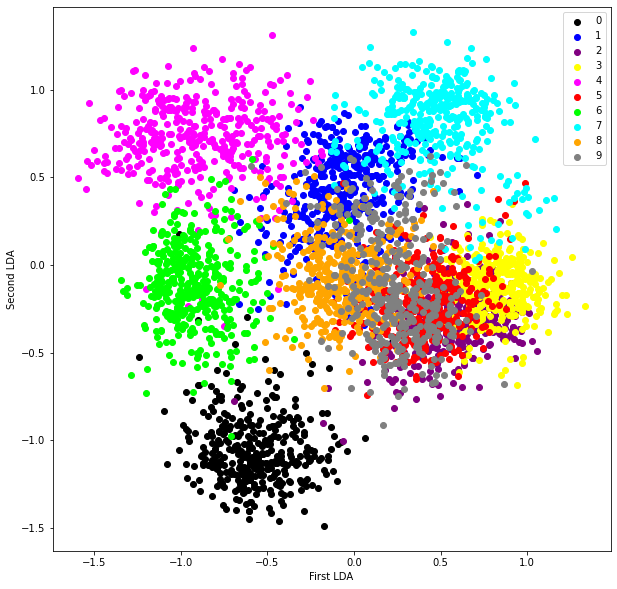

In [34]:
plot_scatter(X_lda,Y_digits)